# Model Creation and Testing for DHI Predictions

In [24]:
import tensorflow as tf
import pandas as pd
from os import listdir
from sklearn import preprocessing
import sklearn as sklearn
import datetime
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot
from sklearn.ensemble import RandomForestRegressor
font_size=12
csfont = {'fontname':'Times New Roman'}
cities = ['BarrancoMinas', 'Bogota', 'Caruru', 'Chajal', 'Sipi', 'PuertoMerizalde']

## Load Dataset

In [36]:
city = 'BarrancoMinas' # select the city to which you wish to create a model
preprocess = True # if preprocess is set to true, then the data will be standarized


def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]
def load_csv(city, preprocess):
    csv_list_train = find_csv_filenames('./Data_set_with_feature_engineering/train/')
    csv_list_test = find_csv_filenames('./Data_set_with_feature_engineering/test/')

    for i, name in enumerate(csv_list_train):
        if city in name:
            df = pd.read_csv(r'./Data_set_with_feature_engineering/train/{}'.format(name), index_col=None)
            train_x = df.iloc[:, 0:-1]
            train_y = df.iloc[:,-1]

            df = pd.read_csv(r'./Data_set_with_feature_engineering/test/{}'.format(csv_list_test[i]), index_col=None)
            test_x = df.iloc[:, 0:-1]
            test_y = df.iloc[:,-1]

    #------ Create tf dataset from the csv file downloaded and preprocess if using nn -----------------------------

    if preprocess:
        standard_scaler = preprocessing.StandardScaler()
        x_train_scaled = standard_scaler.fit_transform(train_x)
        train_x = pd.DataFrame(x_train_scaled)
        test_x = pd.DataFrame(standard_scaler.transform(test_x))


    train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))

    train_dataset = train_dataset.shuffle(len(train_dataset)).batch(64)

    test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y)).batch(64)

    return train_x, train_y, test_x, test_y, train_dataset, test_dataset

train_x, train_y, test_x, test_y, train_dataset, test_dataset = load_csv(city, preprocess)

# for feat, targ in train_dataset.take(5):
#     print ('Features: {}, Target: {}'.format(feat, targ))

## Create, Train and Save Model

In [38]:
def get_compiled_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input((8,)),
        tf.keras.layers.Dense(128, activation='selu', kernel_initializer="lecun_uniform"),
        tf.keras.layers.Dense(128, activation='selu', kernel_initializer="lecun_uniform"),
        tf.keras.layers.Dense(128, activation='selu', kernel_initializer="lecun_uniform"),
        tf.keras.layers.Dense(128, activation='selu', kernel_initializer="lecun_uniform"),
        #tf.keras.layers.Dense(128, activation='selu'),
        tf.keras.layers.Dense(1)
    ])
    #ndam 7 selu standarization 128*4, bs = 64
    model.compile(optimizer='nadam', loss='mse', metrics=tf.keras.metrics.RootMeanSquaredError())
    return model


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1152      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 50,817
Trainable params: 50,817
Non-trainable params: 0
_________________________________________________________________


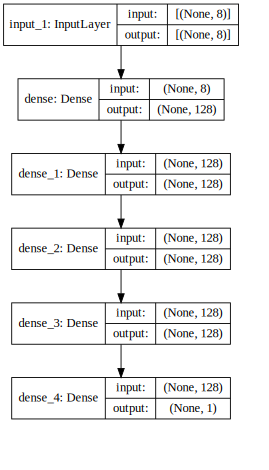

In [39]:
model = get_compiled_model()
model.summary()
model_to_dot(model, show_shapes = True, expand_nested = True, dpi = 65)
SVG(model_to_dot(model, show_shapes = True, expand_nested = True, dpi = 65).create(prog='dot', format='svg'))

In [41]:
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint_filepath = 'chk_points/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_root_mean_squared_error',
    save_weights_only=True,
    save_freq='epoch',
    verbose=1,
    save_best_only=True)


history = model.fit(train_dataset, validation_data=test_dataset, epochs=100, callbacks=[model_checkpoint_callback])
model.load_weights('chk_points/')

Epoch 1/100
1155/1155 [==============================] - 13s 10ms/step - loss: 9909.0607 - root_mean_squared_error: 89.4647 - val_loss: 261.9649 - val_root_mean_squared_error: 16.1853

Epoch 00001: val_root_mean_squared_error improved from inf to 16.18533, saving model to chk_points\
Epoch 2/100
1155/1155 [==============================] - 12s 10ms/step - loss: 124.2985 - root_mean_squared_error: 11.1473 - val_loss: 209.1070 - val_root_mean_squared_error: 14.4605

Epoch 00002: val_root_mean_squared_error improved from 16.18533 to 14.46053, saving model to chk_points\
Epoch 3/100
1155/1155 [==============================] - 14s 12ms/step - loss: 93.7400 - root_mean_squared_error: 9.6778 - val_loss: 111.0578 - val_root_mean_squared_error: 10.5384

Epoch 00003: val_root_mean_squared_error improved from 14.46053 to 10.53840, saving model to chk_points\
Epoch 4/100
1155/1155 [==============================] - 16s 14ms/step - loss: 83.2776 - root_mean_squared_error: 9.1189 - val_loss: 98.300

1155/1155 [==============================] - 16s 14ms/step - loss: 46.4935 - root_mean_squared_error: 6.8152 - val_loss: 57.9111 - val_root_mean_squared_error: 7.6099

Epoch 00032: val_root_mean_squared_error did not improve from 7.23828
Epoch 33/100
1155/1155 [==============================] - 15s 13ms/step - loss: 44.6052 - root_mean_squared_error: 6.6769 - val_loss: 59.3824 - val_root_mean_squared_error: 7.7060

Epoch 00033: val_root_mean_squared_error did not improve from 7.23828
Epoch 34/100
1155/1155 [==============================] - 18s 15ms/step - loss: 45.0051 - root_mean_squared_error: 6.7074 - val_loss: 49.2987 - val_root_mean_squared_error: 7.0213

Epoch 00034: val_root_mean_squared_error improved from 7.23828 to 7.02131, saving model to chk_points\
Epoch 35/100
1155/1155 [==============================] - 14s 12ms/step - loss: 45.5391 - root_mean_squared_error: 6.7455 - val_loss: 50.5400 - val_root_mean_squared_error: 7.1092

Epoch 00035: val_root_mean_squared_error did n

1155/1155 [==============================] - 14s 12ms/step - loss: 43.0305 - root_mean_squared_error: 6.5574 - val_loss: 56.6467 - val_root_mean_squared_error: 7.5264

Epoch 00064: val_root_mean_squared_error did not improve from 6.94787
Epoch 65/100
1155/1155 [==============================] - 14s 12ms/step - loss: 41.1220 - root_mean_squared_error: 6.4057 - val_loss: 49.0737 - val_root_mean_squared_error: 7.0053

Epoch 00065: val_root_mean_squared_error did not improve from 6.94787
Epoch 66/100
1155/1155 [==============================] - 16s 14ms/step - loss: 40.8326 - root_mean_squared_error: 6.3875 - val_loss: 51.5768 - val_root_mean_squared_error: 7.1817

Epoch 00066: val_root_mean_squared_error did not improve from 6.94787
Epoch 67/100
1155/1155 [==============================] - 14s 12ms/step - loss: 41.7976 - root_mean_squared_error: 6.4628 - val_loss: 49.4354 - val_root_mean_squared_error: 7.0310

Epoch 00067: val_root_mean_squared_error did not improve from 6.94787
Epoch 68/


Epoch 00096: val_root_mean_squared_error did not improve from 6.92228
Epoch 97/100
1155/1155 [==============================] - 13s 11ms/step - loss: 40.0788 - root_mean_squared_error: 6.3284 - val_loss: 52.5739 - val_root_mean_squared_error: 7.2508

Epoch 00097: val_root_mean_squared_error did not improve from 6.92228
Epoch 98/100
1155/1155 [==============================] - 13s 11ms/step - loss: 40.6778 - root_mean_squared_error: 6.3757 - val_loss: 48.0450 - val_root_mean_squared_error: 6.9314

Epoch 00098: val_root_mean_squared_error did not improve from 6.92228
Epoch 99/100
1155/1155 [==============================] - 14s 12ms/step - loss: 41.7124 - root_mean_squared_error: 6.4563 - val_loss: 52.3591 - val_root_mean_squared_error: 7.2360

Epoch 00099: val_root_mean_squared_error did not improve from 6.92228
Epoch 100/100
1155/1155 [==============================] - 12s 10ms/step - loss: 38.9021 - root_mean_squared_error: 6.2352 - val_loss: 54.2363 - val_root_mean_squared_error: 7.

## Save Model

In [42]:
model.save('models/{}_model_NN'.format(city))

INFO:tensorflow:Assets written to: models/BarrancoMinas_model_NN\assets


## Load Model for Testing
Use this if you already have saved the model that performed best

In [343]:
model = tf.keras.models.load_model('models/{}_model_NN'.format(city))

## Metrics

In [47]:
def MBE(y_true, y_pred):
    '''
    Parameters:
        y_true (array): Array of observed values
        y_pred (array): Array of prediction values

    Returns:
        mbe (float): Biais score
    '''
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_true = y_true.reshape(len(y_true),1)
    y_pred = y_pred.reshape(len(y_pred),1)   
    diff = np.abs(y_true-y_pred)
    mbe = diff.mean()
    return mbe

In [48]:
rmse = model.evaluate(test_dataset)[1]
predictions = model.predict(test_dataset)
print("The Coefficient of determination over the test data is ", sklearn.metrics.r2_score(test_y, predictions))
print("The MBE over the test data is ", MBE(test_y, predictions))
print('The RMSE metric over the test data is ', rmse )

255/255 [==============================] - 1s 3ms/step - loss: 43.8537 - root_mean_squared_error: 6.6222
The Coefficient of determination over the test data is  0.9979814158868292
The MBE over the test data is  2.8704056412525834
The RMSE metric over the test data is  6.6222100257873535


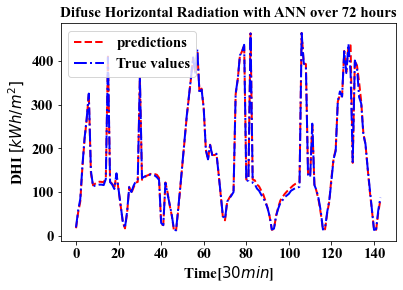

In [45]:
plt.figure()
plt.rcParams['figure.figsize'] = (11, 9)
plt.plot(predictions[0:144],'--r', label='predictions', linewidth=2)
plt.plot(test_y[0:144],'-.b', label='True values', linewidth=2)
plt.legend(loc='upper left', fontsize=15)
plt.xlabel("Time[$30min$]", fontsize=15)
plt.xticks(size=15)
plt.ylabel("DHI $[kWh/m^2]$", fontsize=15)
plt.yticks(size=15)
plt.title('Difuse Horizontal Radiation with ANN over 72 hours', fontsize=15)
plt.savefig('img/DHI_72hours_{}.png'.format(city))
plt.show()

### All Metrics of ANN models

In [52]:
for city_perm in cities:
    train_x, train_y, test_x, test_y, train_dataset, test_dataset = load_csv(city_perm, True)
    model = tf.keras.models.load_model('models/{}_model_NN'.format(city_perm))
    predictions_ = model.predict(test_x)
    rmse_ = model.evaluate(test_dataset)[1]
    print(city_perm)
    print("The Coefficient of determination over the test data is ", sklearn.metrics.r2_score(test_y, predictions_))
    print("The MBE over the test data is ", MBE(test_y, predictions_))
    print('The RMSE metric over the test data is ', rmse_ )

258/258 [==============================] - 1s 3ms/step - loss: 47.9180 - root_mean_squared_error: 6.9223
BarrancoMinas
The Coefficient of determination over the test data is  0.9977370724067199
The MBE over the test data is  3.063739845250919
The RMSE metric over the test data is  6.9222846031188965
254/254 [==============================] - 1s 3ms/step - loss: 40.2640 - root_mean_squared_error: 6.3454
Bogota
The Coefficient of determination over the test data is  0.9981802784116576
The MBE over the test data is  2.696437372930081
The RMSE metric over the test data is  6.345394134521484
257/257 [==============================] - 1s 3ms/step - loss: 49.0937 - root_mean_squared_error: 7.0067
Caruru
The Coefficient of determination over the test data is  0.997769766558083
The MBE over the test data is  3.1310229560849265
The RMSE metric over the test data is  7.006692409515381
259/259 [==============================] - 1s 4ms/step - loss: 38.5305 - root_mean_squared_error: 6.2073
Chajal
T

## Feature Importance

1155/1155 [==============================] - 3s 3ms/step - loss: 13053.6758 - root_mean_squared_error: 114.2527


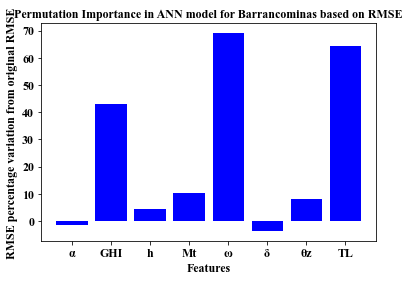

1129/1129 [==============================] - 3s 3ms/step - loss: 36.0205 - root_mean_squared_error: 6.0017


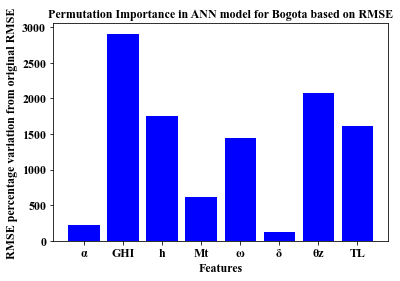

1146/1146 [==============================] - 3s 3ms/step - loss: 41.8337 - root_mean_squared_error: 6.4679


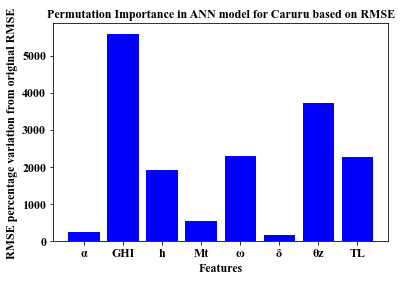

1150/1150 [==============================] - 3s 3ms/step - loss: 34.2830 - root_mean_squared_error: 5.8552


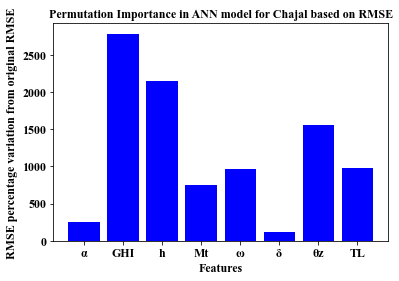

1129/1129 [==============================] - 4s 3ms/step - loss: 37.0359 - root_mean_squared_error: 6.0857


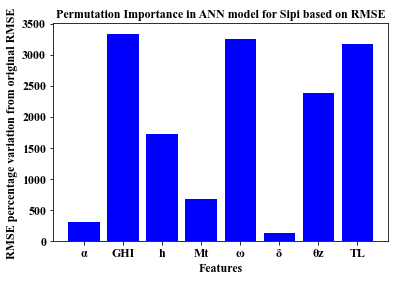

1130/1130 [==============================] - 3s 3ms/step - loss: 36.7308 - root_mean_squared_error: 6.0606


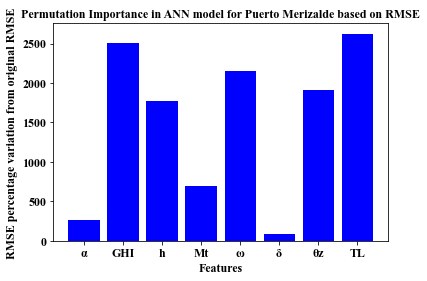

In [27]:
for city_perm in cities:
    train_x, train_y, _, _, train_dataset, _ = load_csv(city_perm, True)
    rmse_list_perm = []
    model = tf.keras.models.load_model('models/{}_model_NN'.format(city_perm))
    for i in range(len(train_x.columns)):
        train_x_perm = train_x.copy()
        train_x_perm[i] = np.random.permutation(train_x[i].values)
        train_dataset_perm = tf.data.Dataset.from_tensor_slices((train_x_perm, train_y)).batch(64)
        rmse_list_perm.append(model.evaluate(train_dataset_perm)[1])
    remse_train = model.evaluate(train_dataset)[1]
    if city_perm == 'BarrancoMinas':
        city_perm = 'Barrancominas'
    elif city_perm == 'PuertoMerizalde':
        city_perm = 'Puerto Merizalde'
    plt.bar(range(train_x.shape[1]), (np.array(rmse_list_perm) - remse_train)/(remse_train)*100,color = 'blue')
    plt.xticks(range(train_x.shape[1]), ['\u03B1', 'GHI', 'h', 'Mt', '\u03C9', '\u03B4', '\u03B8z', 'TL'],fontsize=font_size )
    plt.ylabel('RMSE percentage variation from original RMSE',fontsize=font_size)
    plt.xlabel('Features', fontsize=font_size)
    plt.yticks(size=font_size)
    plt.savefig('img/PM{}.png'.format(city_perm))
    plt.title('Permutation Importance in ANN model for {} based on RMSE'.format(city_perm),fontsize=font_size)
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
    plt.show()

## Random Forest Feature Importance

In [5]:
rf_reg = RandomForestRegressor(n_estimators=100, criterion='mse')

In [6]:
rf_reg.fit(train_x, train_y)

RandomForestRegressor()

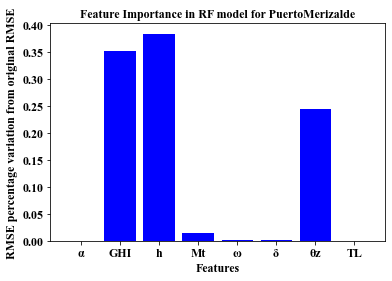

In [21]:
plt.bar(range(test_x.shape[1]), rf_reg.feature_importances_,color = 'blue')
plt.xticks(range(test_x.shape[1]), ['\u03B1', 'GHI', 'h', 'Mt', '\u03C9', '\u03B4', '\u03B8z', 'TL'],fontsize=font_size )
plt.ylabel('Feature Importance',fontsize=font_size)
plt.xlabel('Features', fontsize=font_size)
plt.yticks(size=font_size)
plt.savefig('img/FIRF_{}.png'.format(city))
plt.title('Feature Importance in RF model for {}'.format(city),fontsize=font_size)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.show()

In [489]:
predictions_RF = rf_reg.predict(test_x)
print("The Coefficient of determination over the test data is ", sklearn.metrics.r2_score(test_y, predictions_RF))
print("The MBE over the test data is ", MBE(test_y, predictions_RF))
print('The RMSE metric over the test data is ', sklearn.metrics.mean_squared_error(test_y, predictions_RF, squared=False) )

The Coefficient of determination over the test data is  0.9976081796783078
The MBE over the test data is  -0.4396279264596307
The RMSE metric over the test data is  7.208483305618184
